# NLP using PyTorch

## [Source](https://www.datacamp.com/tutorial/nlp-with-pytorch-a-comprehensive-guide?dc_referrer=https%3A%2F%2Fwww.google.com%2F)


## Tensor

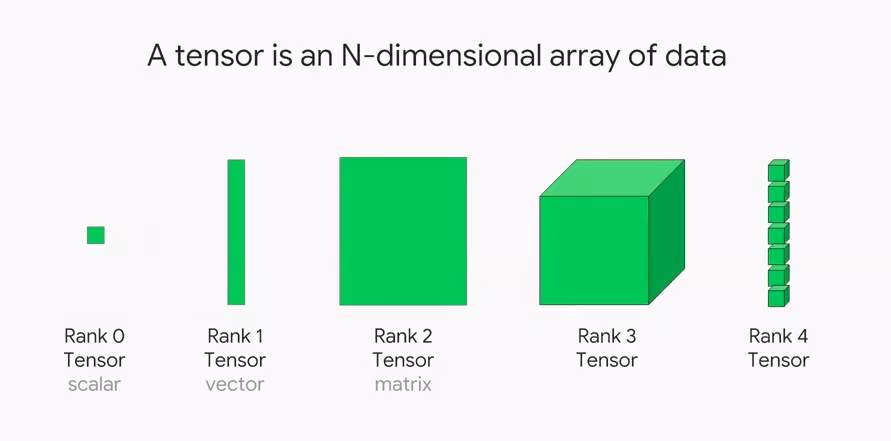

Tensors play a critical role in natural language processing (NLP) tasks due to the inherent sequential and hierarchical nature of language data. NLP involves processing and understanding textual information. Tensors enable the representation and manipulation of text data by encoding words, sentences, or documents as numerical vectors.

This numerical representation allows deep learning models to process and learn from textual data effectively. Tensors enable the efficient handling of large-scale language datasets, facilitate the training of neural networks, and enable advanced techniques like attention mechanisms for more accurate NLP models.

| Feature                  | NumPy Array                                   | PyTorch Tensor                                           |
| ------------------------ | --------------------------------------------- | -------------------------------------------------------- |
| **Device**               | CPU only                                      | CPU or GPU (`tensor.to('cuda')`)                         |
| **Autograd / Gradients** | No gradient tracking                          | Can track gradients automatically (`requires_grad=True`) |
| **ML Integration**       | Needs conversion to tensor for PyTorch models | Directly usable in PyTorch models                        |
| **Indexing / Slicing**   | Similar to standard Python arrays             | Very similar to NumPy, mostly compatible                 |
| **Operations**           | Standard linear algebra & math                | Same as NumPy + GPU support + autograd                   |


## Word embedding

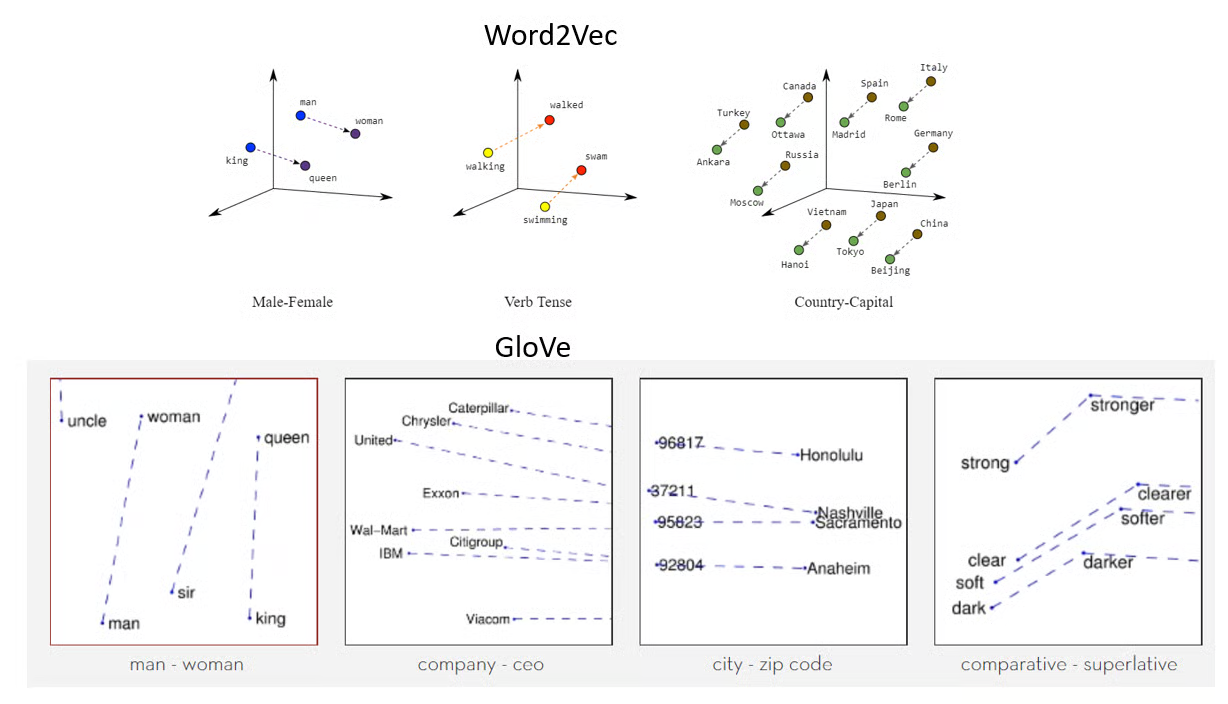

In simple terms, embeddings are a clever way of representing words as numbers. These numbers have special meanings that capture how words are related to each other. It's like a secret code that helps computers understand and work with words more easily.

Word2Vec and GloVe are two popular methods for generating word embeddings. Word2Vec is a neural network-based model that learns word representations by predicting the surrounding words given a target word (continuous bag of words - CBOW) or predicting the target word based on its context (skip-gram).

GloVe (Global Vectors for Word Representation) is a count-based method that constructs word vectors based on the co-occurrence statistics of words in a large corpus. It captures global word relationships and often leads to better performance in word analogy tasks.

## NLP model architecture

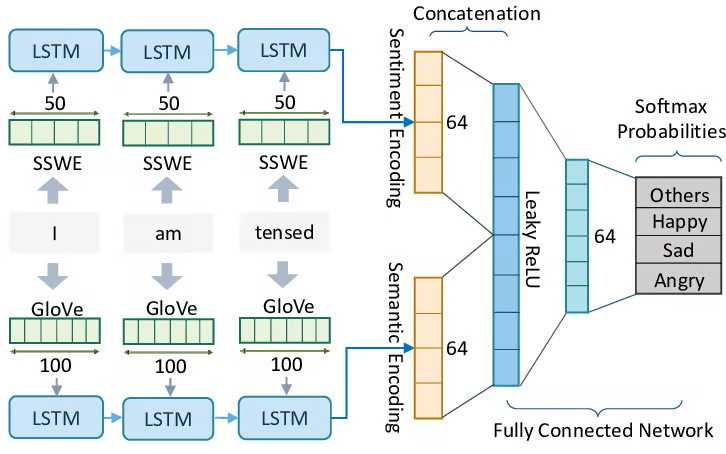

Sentiment Analysis is a common task in NLP where the objective is to understand the sentiment expressed in a piece of text, often classified as positive, negative, or neutral. To tackle this task, a simple recurrent neural network (RNN) or a more advanced version called long short-term memory (LSTM) can be used.

### RNN: recurrent neural network
RNN architecture processes the text sequentially, where each word is input one after another. The network maintains a hidden state that changes with each word input, capturing the information from the sequence processed so far.

This hidden state acts as the memory of the network. However, standard RNNs struggle with long sequences due to what's known as the vanishing gradient problem, where the contribution of information decays geometrically over time, making the network forget the earlier inputs.

### LSTM: long short-term memory 
To combat this, LSTM, a variant of RNN, was developed. An LSTM maintains a longer context or 'memory' by having a more complex internal structure in its hidden state. It has a series of 'gates' (input, forget, and output gate) that control the flow of information in and out of the memory state.

The input gate determines how much of the incoming information should be stored in the memory state. The forget gate decides what information should be discarded, and the output gate defines how much of the internal state is exposed to the next LSTM unit in the sequence.

RNN or LSTM model would take a sequence of words in a sentence or document as the input. Each word is typically represented as a dense vector, or embedding, which captures the semantic meaning of the word.

The network processes the sequence word by word, updating its internal state based on the current word and the previous state.

The final state of the network is then used to predict the sentiment. It is passed through a fully connected layer, followed by a softmax activation function to output a probability distribution over the sentiment classes (e.g., positive, negative, neutral).

The class with the highest probability is chosen as the model's prediction.

This is a basic setup and can be further enhanced with techniques such as bidirectional LSTMs (which process the sequence in both directions), and attention mechanisms (which allow the model to focus on important parts of the sequence), among others.

## Training LSTM Model in PyTorch for Sentiment Analysis

## 1. Load the dataset

In this example, we will be using the IMDB dataset of 50K Movie reviews. The goal is to train a LSTM model to predict the sentiment. There are two possible values: 'positive’ and ‘negative’. Hence this is a binary classification task.

[data source](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [ ]:
import pandas as pd
import os

current_dir = os.getcwd()
path = os.path.join(current_dir, 'IMDB Dataset.csv')

df = pd.read_csv(path)
df.head()

## 2. Exploratory data analysis

In [ ]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'train data shape: {x_train.shape}')
print(f'test data shape: {x_test.shape}')

dd = pd.Series(y_train).value_counts()

# Plot with matplotlib
plt.bar(['negative', 'positive'], dd.values)
plt.ylabel('Count')
plt.title('Class distribution in training set')
plt.show()


## 3. Text preprocessing

Text preprocessing and tokenization is a critical first step. First, we clean up the text data by removing punctuation, extra spaces, and numbers.

We then transform sentences into individual words, remove common words (known as "stop words"), and keep track of the 1000 most frequently used words in the dataset. These words are then assigned a unique identifier, forming a dictionary for one-hot encoding.

The code essentially is converting the original text sentences into sequences of these unique identifiers, translating human language into a format that a machine learning model can understand.

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words

In [71]:
import re
from collections import Counter
from nltk.corpus import stopwords
import torch
from torch.nn.utils.rnn import pad_sequence

def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)   # remove punctuation
    s = re.sub(r"\s+", '', s)       # remove spaces
    s = re.sub(r"\d", '', s)        # remove digits
    return s

def tokenize(x_train, y_train, x_val, y_val):
    word_list = []
    stop_words = set(stopwords.words('english'))

    # Create a list of all words in the training set
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    '''
    x_train = ["The movie was good", "I liked the film"]
    word_list = ['movie', 'good', 'liked', 'film']
    '''

    # Frequency dict: how often each word appears in the training set
    corpus = Counter(word_list)
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000] # top 1000 repeated words
    onehot_dict = {w: i+1 for i, w in enumerate(corpus_)}  # word → ID

    '''onehot_dict = {'movie': 1, 'good': 2, 'liked': 3, 'film': 4}'''

    # convert sentences to IDs
    final_list_train, final_list_test = [], []
    for sent in x_train:
        final_list_train.append([
            onehot_dict[preprocess_string(word)] 
            for word in sent.lower().split()
            if preprocess_string(word) in onehot_dict
        ])
    for sent in x_val:
        final_list_test.append([
            onehot_dict[preprocess_string(word)] 
            for word in sent.lower().split()
            if preprocess_string(word) in onehot_dict
        ])

    '''The movie was good → [1, 2]'''
    
    # convert labels
    encoded_train = [1 if label == 'positive' else 0 for label in y_train]
    encoded_test  = [1 if label == 'positive' else 0 for label in y_val]

    # Convert to tensors + pad
    '''
    Padding is needed because PyTorch expect inputs in batches that have the same shape.
    Here’s the problem:
    Each sentence has a different number of words:

    ["I love ML"] → 3 words → [1, 2, 3]
    ["This movie was amazing"] → 4 words → [4, 5, 6, 7]
    '''

    final_list_train = [torch.tensor(seq) for seq in final_list_train]
    final_list_test  = [torch.tensor(seq) for seq in final_list_test]

    x_train_padded = pad_sequence(final_list_train, batch_first=True, padding_value=0)
    x_test_padded  = pad_sequence(final_list_test, batch_first=True, padding_value=0)

    '''[[1,2,3], [4,5]] → [[1,2,3],[4,5,0]]'''

    y_train_tensor = torch.tensor(encoded_train)
    y_test_tensor  = torch.tensor(encoded_test)

    return x_train_padded, y_train_tensor, x_test_padded, y_test_tensor, onehot_dict

x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)



### Example to learn the code above

### Example dataset

```python
x_train = ["I love ML", "This movie was amazing", "Bad film"]
y_train = ["positive", "positive", "negative"]

x_val = ["Good movie", "I hated it"]
y_val = ["positive", "negative"]
```

---

### Step 1️⃣ Preprocess each word

We clean each word: remove punctuation, spaces, digits.

```python
preprocess_string("I")        → "I"
preprocess_string("love")     → "love"
preprocess_string("ML")       → "ML"
preprocess_string("movie")    → "movie"
preprocess_string("was")      → "was"
preprocess_string("amazing")  → "amazing"
preprocess_string("Bad")      → "Bad"
preprocess_string("film")     → "film"
```

* Stopwords like `"was"` are removed.
* Only meaningful words remain.

After removing stopwords:

```python
x_train cleaned → [["I", "love", "ML"], ["movie", "amazing"], ["Bad", "film"]]
```

---

### Step 2️⃣ Count word frequencies in training set

```python
word_list = ["I", "love", "ML", "movie", "amazing", "Bad", "film"]
corpus = Counter(word_list)
```

* Each word appears once here.
* Let’s assume top 5 words (for simplicity):

```python
corpus_ = ["I", "love", "ML", "movie", "amazing"]
onehot_dict = { "I":1, "love":2, "ML":3, "movie":4, "amazing":5 }
```

* Words not in top 5, like `"Bad"` or `"film"`, will be ignored.

---

### Step 3️⃣ Convert sentences → sequences of IDs

```python
final_list_train = [
    [onehot_dict[word] for word in sentence if word in onehot_dict]
    for sentence in cleaned x_train
]
```

Result:

```python
["I love ML"]          → [1, 2, 3]
["movie amazing"]      → [4, 5]
["Bad film"]           → []  # ignored because "Bad" and "film" not in top 5
```

* So `final_list_train = [[1,2,3], [4,5], []]`.

---

### Step 4️⃣ Encode labels

```python
encoded_train = [1 if label=="positive" else 0 for label in y_train]
```

Result:

```python
encoded_train = [1, 1, 0]
```

---

### Step 5️⃣ Convert to tensors

```python
final_list_train = [torch.tensor(seq) for seq in final_list_train]
```

* `[1,2,3] → tensor([1,2,3])`
* `[4,5] → tensor([4,5])`
* `[] → tensor([])`

---

### Step 6️⃣ Pad sequences

Use `pad_sequence` so all sentences have **same length**:

```python
x_train_padded = pad_sequence(final_list_train, batch_first=True, padding_value=0)
```

### How padding works here:

| Original sequence | After padding (length = 3) |
| ----------------- | -------------------------- |
| [1, 2, 3]         | [1, 2, 3]                  |
| [4, 5]            | [4, 5, 0]                  |
| []                | [0, 0, 0]                  |

* All sequences now have **length 3**, so PyTorch can create a proper 2D tensor:

```python
x_train_padded = 
tensor([
    [1, 2, 3],
    [4, 5, 0],
    [0, 0, 0]
])
```

---

### Step 7️⃣ Convert labels to tensor

```python
y_train_tensor = torch.tensor(encoded_train)
```

Result:

```python
y_train_tensor = tensor([1, 1, 0])
```

---

✅ Now you have:

* `x_train_padded` → 2D tensor `[num_sentences, max_length]`
* `y_train_tensor` → labels tensor `[num_sentences]`
* Same procedure applies for validation set.


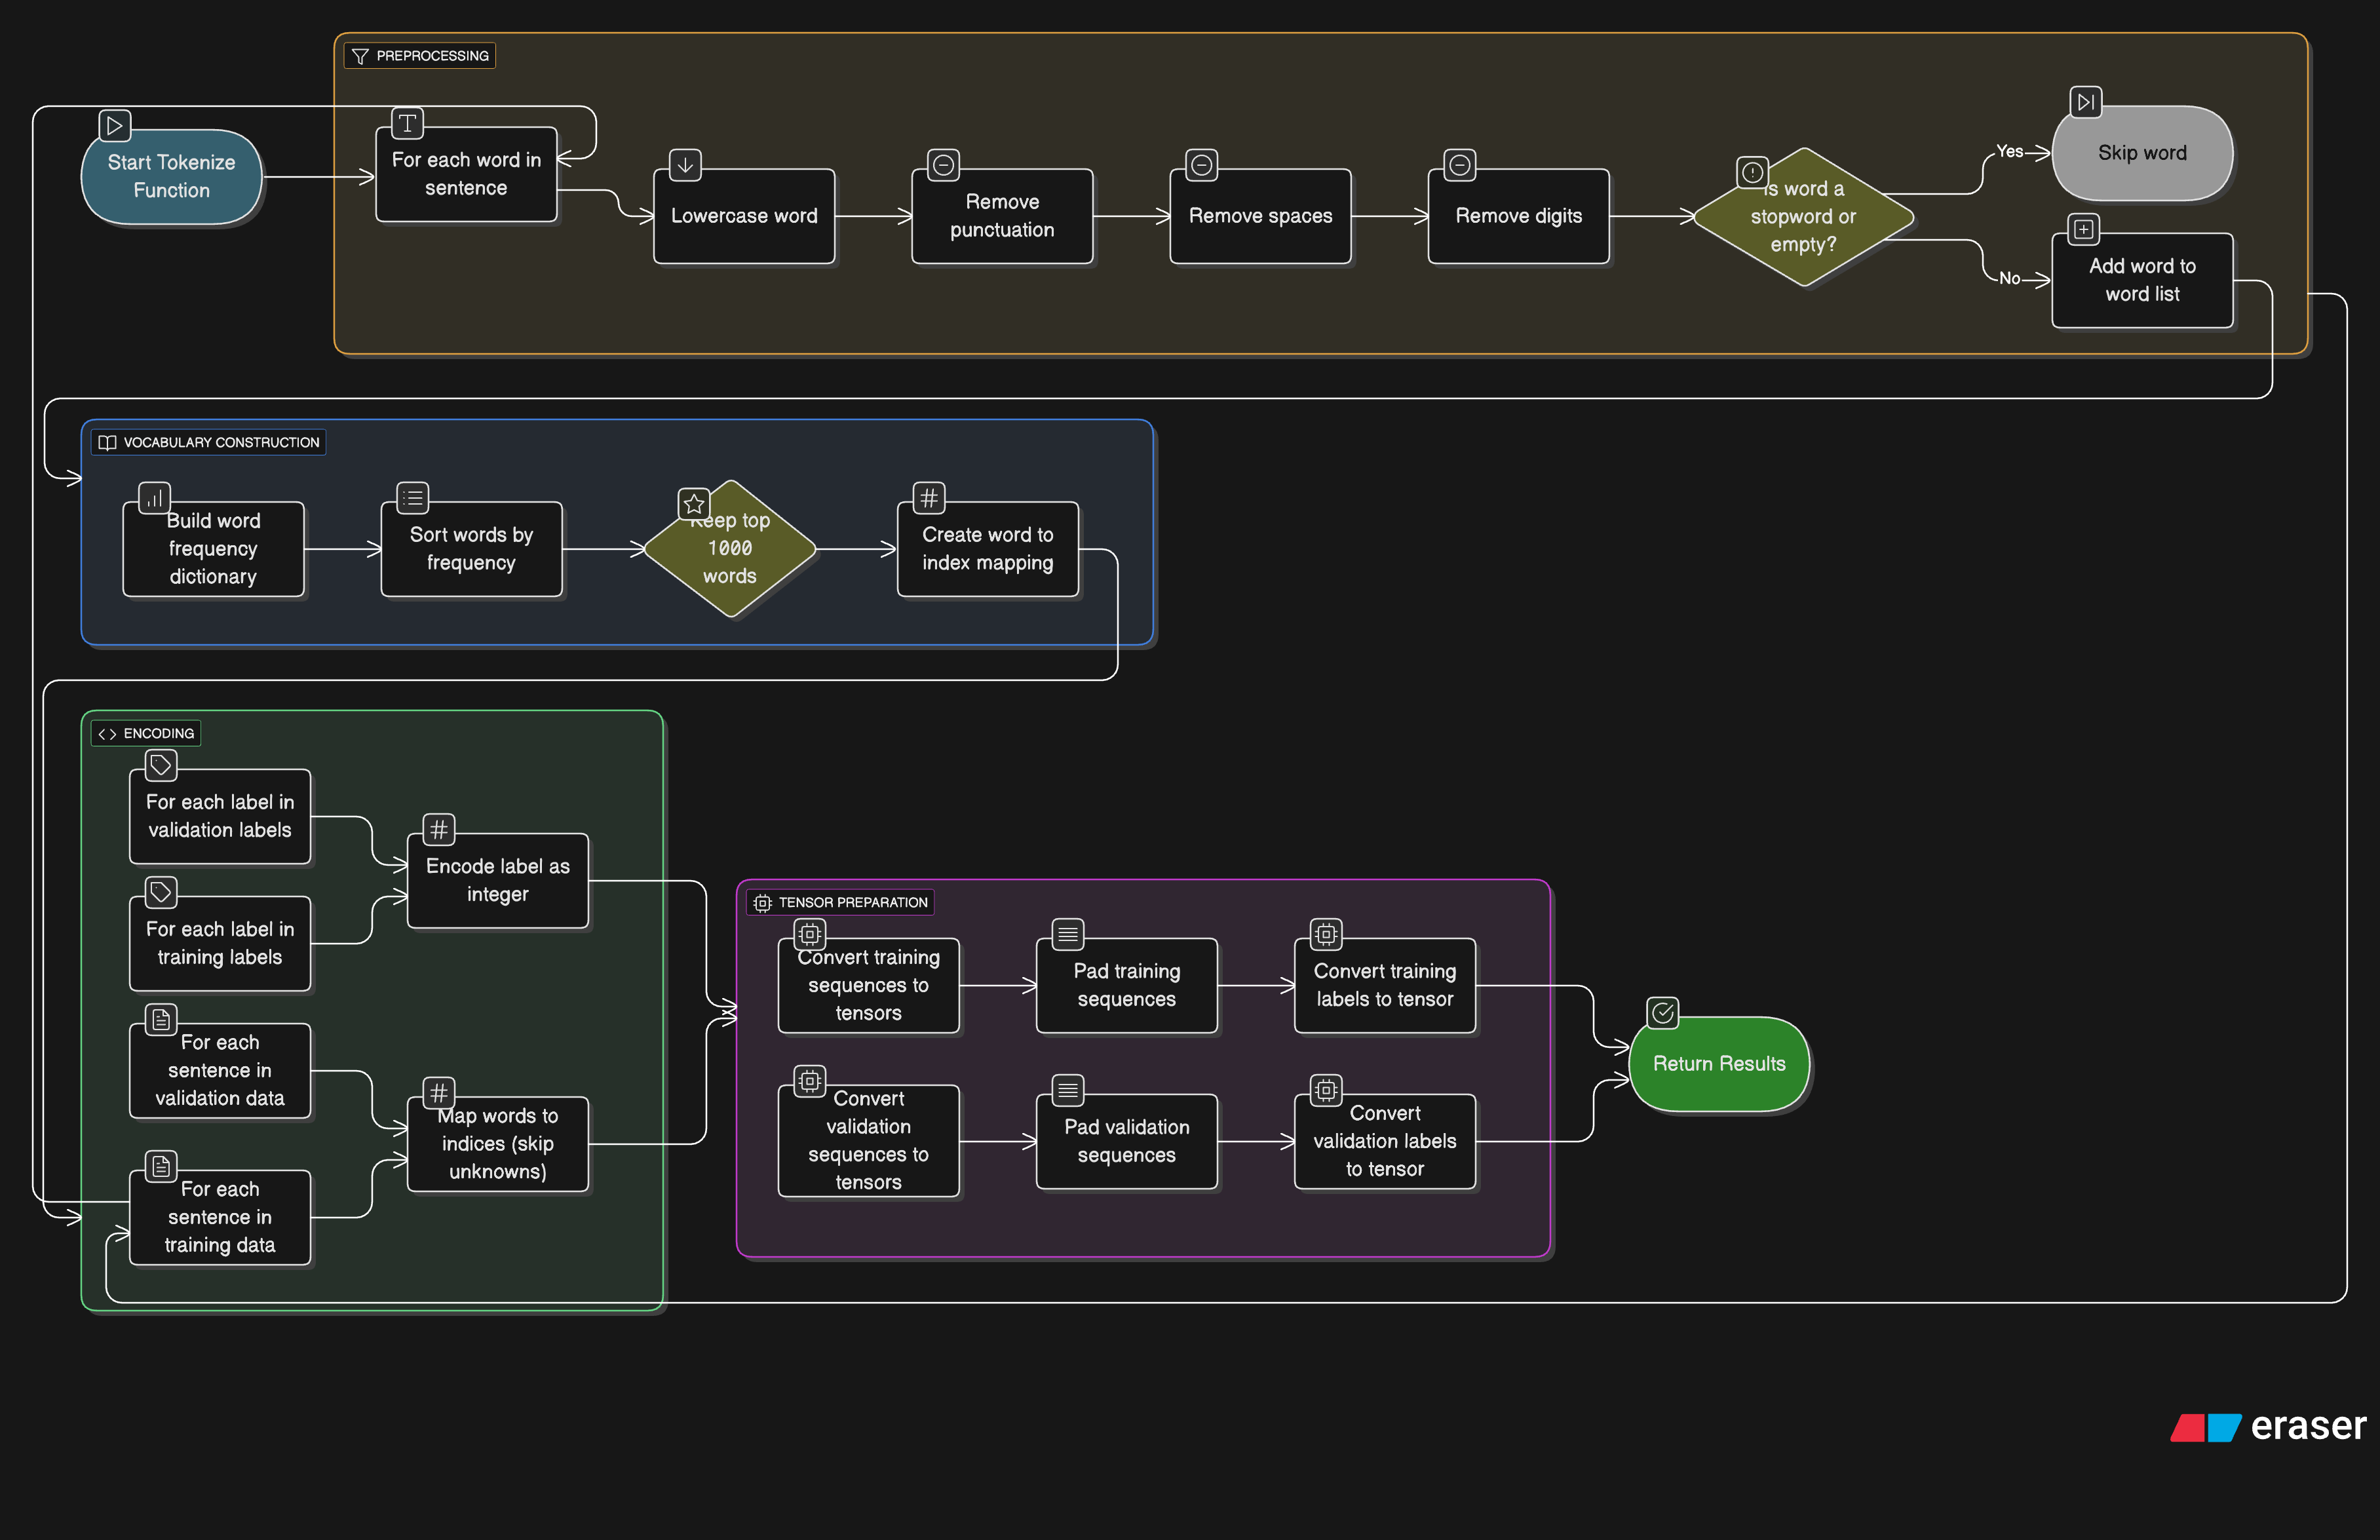

In [74]:
x_train

tensor([[901,  40, 329,  ...,   0,   0,   0],
        [ 79, 151, 263,  ...,   0,   0,   0],
        [108,  19, 864,  ...,   0,   0,   0],
        ...,
        [330,   9,  30,  ...,   0,   0,   0],
        [126,   2, 343,  ...,   0,   0,   0],
        [  2, 202, 174,  ...,   0,   0,   0]])

## 4. 4. Preparing the data for the model

Given the variable token lengths of each review, it's necessary to standardize them for consistency. As the majority of reviews contain less than 500 tokens, we'll establish 500 as the fixed length for all reviews.

In [ ]:
from torch.nn.utils.rnn import pad_sequence

x_train_pad = pad_sequence(x_train, batch_first=True, padding_value=0)
x_test_pad  = pad_sequence(x_test, batch_first=True, padding_value=0)

| Original sequence | After padding (max length = 4) |
| ----------------- | ------------------------------ |
| [1, 2, 3]         | [0, 1, 2, 3]                   |
| [4, 5]            | [0, 0, 4, 5]                   |
| [6, 7, 8, 9]      | [6, 7, 8, 9]                   |

Next, we use DataLoader class to create the final dataset for model training.

In [83]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
# Make sure x_train_pad, y_train etc. are tensors
train_data = TensorDataset(x_train_pad, y_train)
valid_data = TensorDataset(x_test_pad, y_test)

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 652])
Sample input: 
 tensor([[296,  99, 575,  ...,   0,   0,   0],
        [624,   2, 624,  ...,   0,   0,   0],
        [769, 111,  38,  ...,   0,   0,   0],
        ...,
        [124, 208, 575,  ...,   0,   0,   0],
        [517, 981,  46,  ...,   0,   0,   0],
        [263, 750, 490,  ...,   0,   0,   0]])
Sample output: 
 tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0])
